Bessel's equation of order $n$ is the linear second order ordinary differential equation
\begin{equation}
    x^2y'' + xy' + (x^2 - n^2)y = 0.
\end{equation}
Bessel functions of the 2nd kind, denoted  $Y_n(x)$ are the solutions which are infinite at $x = 0$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, quad
from scipy.special import yv, yvp

def bessel_ode(x, y, n):
    '''
    Represents Bessel's 2nd order ODE as a system of two first-order ODEs.
    x^2y'' + xy' + (x^2 - n^2)y = 0
    y0 = y,  y1 = y'
    y0' = y1
    y1' = y'' = -(1/t)y1 - (1 - n^2/t^2)y0

    Args:
        x: The independent variable.
        y: An array [y0, y1].
        n: The order of the Bessel equation.
    Returns:
        An array [y0', y1'].
    '''
    # Guard against division by zero at t=0.
    if x == 0:
        return np.array([0, 0])

    y0, y1 = y
    y0_dot = y1
    y1_dot = -(1/x) * y1 - (1 - n**2 / x**2) * y0
    return np.array([y0_dot, y1_dot])

In [ ]:
def get_bessel_Y_via_ode(n, x_eval):
    '''
    Calculates Y_n(x) by solving Bessel's ODE backwards.
    '''
    # To get the Y_n(x) solution (not a mix with J_n(x)), we need the
    # exact initial conditions. We can use SciPy's functions for this.
    # yv(n, x) gives the value J_n(x)
    # yvp(n, x) gives the derivative J'_n(x)
    y0 = [yv(n, x_eval[-1]), yvp(n, x_eval[-1])]

    # Define the backwards time span for the solver.
    t_span = [x_eval[-1], x_eval[0]]
    t_eval_desc = np.flip(x_eval)

    sol = solve_ivp(
        bessel_ode,
        t_span,
        y0,
        args=(n,),
        dense_output=True,
        t_eval=t_eval_desc
    )
    return np.flip(sol.y[0])


In [ ]:
def get_bessel_Y_via_scipy(n, x_eval):
    '''
    Calculates Y_n(x) using the built-in, optimized SciPy function.
    '''
    return yv(n, x_eval)

In [ ]:
def get_bessel_Y_via_integral(n, x_eval):
    '''
    Calculates Y_n(x) by numerically evaluating its integral representation.
    Excellent stability but computationally expensive.
    '''
    # Integrand for the first part (finite integral)
    def integrand1(t, x, n_arg):
        return np.sin(x * np.sin(t) - n_arg * t)

    # Integrand for the second part (infinite integral)
    def integrand2(t, x, n_arg):
        term1 = np.exp(n_arg * t)
        term2 = ((-1)**n_arg) * np.exp(-n_arg * t)
        return (term1 + term2) * np.exp(-x * np.sinh(t))

    yn_values = []
    for x_val in x_eval:
        if x_val <= 0:
            # Handle negative x.
            yn_values.append(np.nan)
            continue

        # Perform the numerical integrations for the current x and n
        integral1_val, _ = quad(integrand1, 0, np.pi, args=(x_val, n))
        integral2_val, _ = quad(integrand2, 0, np.inf, args=(x_val, n))

        # Combine the results according to the general formula
        yn_val = (1.0 / np.pi) * (integral1_val - integral2_val)
        yn_values.append(yn_val)

    return np.array(yn_values)

Calculating Y_0(x) from x=0.1 to 20.0...
Calculations complete.


/tmp/ipython-input-2716967962.py:13: RuntimeWarning: overflow encountered in sinh
  return (term1 + term2) * np.exp(-x * np.sinh(t))


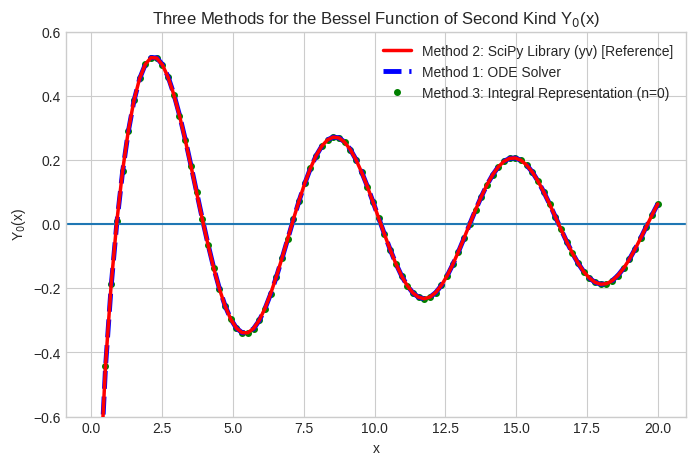

Calculating Y_1(x) from x=0.1 to 20.0...


/tmp/ipython-input-2716967962.py:11: RuntimeWarning: overflow encountered in exp
  term1 = np.exp(n_arg * t)
/tmp/ipython-input-2716967962.py:13: RuntimeWarning: invalid value encountered in scalar multiply
  return (term1 + term2) * np.exp(-x * np.sinh(t))
/tmp/ipython-input-2716967962.py:24: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral2_val, _ = quad(integrand2, 0, np.inf, args=(x_val, n))


Calculations complete.


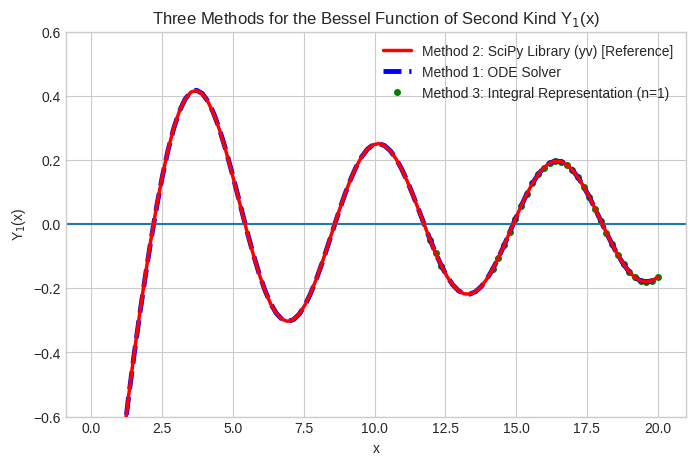

Calculating Y_4(x) from x=0.1 to 20.0...
Calculations complete.


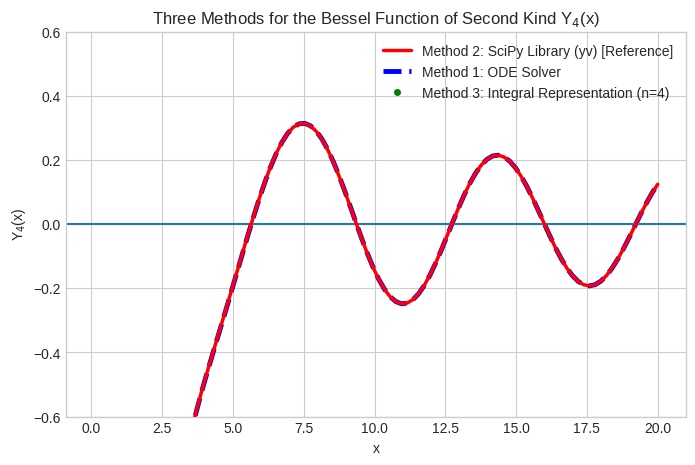

In [ ]:
# --- Parameters ---
N_ORDER = 1
ORDERS = [0, 1, 4]
X_MAX = 20.0
# Start slightly after 0 to avoid the singularity
x_values = np.linspace(0.1, X_MAX, 100)

for N_ORDER in ORDERS:
    # --- Execute all three methods ---
    print(f'Calculating Y_{N_ORDER}(x) from x=0.1 to {X_MAX}...')
    y_ode = get_bessel_Y_via_ode(N_ORDER, x_values)
    y_scipy = get_bessel_Y_via_scipy(N_ORDER, x_values)
    y_integral = get_bessel_Y_via_integral(N_ORDER, x_values)
    print('Calculations complete.')

    # --- Plotting the results ---
    fig, ax = plt.subplots(figsize=(8, 5))

    ax.plot(x_values, y_scipy, 'r-', lw=2.5, label='Method 2: SciPy Library (yv) [Reference]', zorder=3)
    ax.plot(x_values, y_ode, 'b--', lw=3.5, label='Method 1: ODE Solver', zorder=2)
    ax.plot(x_values, y_integral, 'go', markersize=4, label=f'Method 3: Integral Representation (n={N_ORDER})', zorder=1)

    # --- Formatting ---
    ax.set_title(f'Three Methods for the Bessel Function of Second Kind Y$_{N_ORDER}$(x)')
    ax.set_xlabel('x')
    ax.set_ylabel(f'Y$_{N_ORDER}$(x)')
    ax.axhline(0)
    ax.set_ylim(-0.6, 0.6)
    ax.legend()
    ax.grid(True)
    plt.show()